In [18]:
import pandas as pd
 

### This ipynb file does the section wise evaluation as well as removing border pixels for different range 

In [19]:
def analysis_on_edges(df, pixel_range):
    print(len(df))
    '''
    
    df refers to the data frame on which we are going to play around 
    pixel_range for what range of pixels from edges we want to excelude bounding boxes 
    
    '''
    min_p=pixel_range
    max_p= 80-pixel_range
    df['x_center']= df['xmin'] + ((df['xmax']-df['xmin'])/2)
    df['y_center']= df['ymin'] + ((df['ymax']-df['ymin'])/2)
    
    df.drop(df.loc[df['x_center'] < min_p].index, inplace=True)
    df.drop(df.loc[df['y_center'] < min_p].index, inplace=True)
    df.drop(df.loc[df['x_center'] > max_p].index, inplace=True)
    df.drop(df.loc[df['y_center'] > max_p].index, inplace=True)
    
    
    return df



#Below block we set input path and the pixels from boarders if to br removed also IOU is set here 

In [20]:
#please change groundtruth and predicted annotation detaisl here 

df_annotation_ground_truth= pd.read_csv("./test_data.csv")
df_annotations_predicted= pd.read_csv("./output_tflite_quant.csv")
#set pixel range you want to remove 
#keep pixel range same for predicted and ground truth 
#use 0 for no change 
df_annotation_ground_truth= analysis_on_edges(df_annotation_ground_truth, 10)
df_annotations_predicted  =analysis_on_edges(df_annotations_predicted, 10)

given_IOU= 0.0
#set the IPU for which you xant evaluation that is it is constraint eg. if I say 0.50
#Even if there is detection if the overlap with ground truth is not greater than 50% that detection is taken as FP 

image_names_ground_truth= df_annotation_ground_truth['image_name'].unique()
image_names_predicted= df_annotations_predicted['image_name'].unique()
image_name= list(set(image_names_ground_truth) | set(image_names_predicted))


1611
1540


In [21]:
from shapely.geometry import Polygon
#shapely input with all x y coordinates
#Note: The origin of Coordinate Systems in shapely library is left-bottom where origin in computer graphics is left-top. This difference does not affect the IoU calculation, but if you do other types of calculation, this information might be helpful.

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    if poly_1.union(poly_2).area > 0:
        iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
        return iou
    else: return 0.0

In [22]:

def evaluaition_images(ground_truth,predicted):
    '''
    both ground_truth,predicted are sampled data frames for same image 
    first we create alist with all four coordiantes of bounding boxes 
    then recurssive IOU function is run on each ground truth to find best IOU with predictted values 
    the result of this is the list with index wise relation between ground_index, predicted_index, IOU
    #incase we have more predicted or ground truth that are associated with None eg;
    None, predicted_index, None or ground_index, None, None 
    
    At end we will return 3 lists 
    1; ground_truth_coordinate_list basically ground truth info in list format  with all four coordinates 
    

    '''
    # I am taking them in a list format 
    ground_truth_coordinate_list=[]
    predicted_coordinate_list=[]
    
    
    for i in range(len(ground_truth)):
        x1= ground_truth.iloc[i]['xmin']
        y1= ground_truth.iloc[i]['ymin']
        x2= ground_truth.iloc[i]['xmin']
        y2= ground_truth.iloc[i]['ymax']
        x3= ground_truth.iloc[i]['xmax']
        y3= ground_truth.iloc[i]['ymax']
        x4= ground_truth.iloc[i]['xmax']
        y4= ground_truth.iloc[i]['ymin']
            #4 coordinates 
        ground_truth_coordinate_list.append([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
        
    for j in range(len(predicted)):
            
        X1= predicted.iloc[j]['xmin']
        Y1= predicted.iloc[j]['ymin']
        X2= predicted.iloc[j]['xmin']
        Y2= predicted.iloc[j]['ymax']
        X3= predicted.iloc[j]['xmax']
        Y3= predicted.iloc[j]['ymax']
        X4= predicted.iloc[j]['xmax']
        Y4= predicted.iloc[j]['ymin']
        
        confidence_score= predicted.iloc[j]['score'] 
        predicted_coordinate_list.append([[X1,Y1],[X2,Y2],[X3,Y3],[X4,Y4], confidence_score])  
            
            
    def recurrsive_IOU_selection(gt, pd, final):
        #ground truth refers to gt the groiund truth list containing bounding box values in a image 
        #pd predicted input bounding value we are finding IOU with
        #final_related is the final list we will poroduce after IOU has crossed threshold 
        
        '''
        
        The reason we are doing this recurssive is we don't know which ground truth is assosiated to which predicted value as are output
        are just bounding boxes details hence what we do is coompare the best IOU between predictyed adn ground truth and assosicte those 
        ground truth with thoes predicted box values. This will be a recurssive process.
        
        Few heutrics could be applied to lessen the calculation like distance between center of predicted and ground truth if it is greater than 
        sum of diaganol of both then thye don't intersect but I haven't done that. You could try in future versions
        
        '''
        
        
        final_gt_pd= final.copy()
        
        for i in range(len(gt)):
            temp_iou= 0.0
            index_g= None
            index_p= None
            #taking the single value in ground truth list start by First
            box_1= gt[i]
            
            for j in range(len(pd)):
                box_2= pd[j][:-1] #excluding confidence_score as input 
                iou_calc= calculate_iou(box_1, box_2)
                
                #now I am am going to compare it with all the values in the predicted and take best
                if iou_calc>temp_iou:
                    
                    # now check if this predicted is associated with any previous associated ground truth value
                    for o in range(len(final_gt_pd)):
                        if (final_gt_pd[o][1] == j): 
                            if (final_gt_pd[o][2] < iou_calc):
                            #if yes is IOU grater than calculated
                            #if yes take it out 
                                final_gt_pd.pop(o)

                                temp_iou= iou_calc
                                index_p= j
                                index_g= i
                                
                            break
                        
                                
                    else:
                        
                       
                        temp_iou= iou_calc
                        index_p= j
                        index_g= i
                    
                
            if (index_p == None)| (index_g== None): continue
            else: final_gt_pd.append([index_g,index_p,temp_iou])
                
                
        for m in final_gt_pd:
            if m not in final:
                final_gt_pd=recurrsive_IOU_selection(gt, pd, final_gt_pd)
        for k in final:
            if k not in final_gt_pd: 
                final_gt_pd=recurrsive_IOU_selection(gt, pd, final_gt_pd)
        else: return final_gt_pd
           
    grnd_pretd_rel=[]
    
    grnd_pretd_rel_list= recurrsive_IOU_selection(ground_truth_coordinate_list, predicted_coordinate_list, grnd_pretd_rel)
    
    
    #those indexes not assosciated with anyone are associated with None 
    predicted_associated= list()
    ground_associated =list()
    for m in grnd_pretd_rel_list: predicted_associated.append(m[1])
    for n in grnd_pretd_rel_list: ground_associated.append(n[0])
    for k in range(len(ground_truth_coordinate_list)):
        if k not in ground_associated:
            grnd_pretd_rel_list.append([k, None, None])
    for f in range(len(predicted_coordinate_list)):
        if f not in predicted_associated:
            grnd_pretd_rel_list.append([None,f, None])
            
    return ground_truth_coordinate_list, predicted_coordinate_list, grnd_pretd_rel_list
    

In [23]:
def confusion_analysis(ground_truth_coordinate_list, predicted_coordinate_list, relationship_list, given_IOU):
    TP=list()
    FP=list()
    #TN=list() there are no true negatives we have only one class
    FN=list()
    for val in relationship_list:
        #val[2] refers to IOU calculated 
        #if it is None that means it is either FP or FN 
        if val[2]== None:
            if val[0]==None:FP.append(val)
            elif val[1]==None: FN.append(val)
        else:
            if val[2]>= given_IOU:
                TP.append(val)
            else: #if IOU calculated is less
                FN.append(val) # they will be seen as False negatives
    return TP, FP, FN
                
def area_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP, FN):
    from shapely.geometry import Polygon
    TP_areas=list()
    #for true postive we can take either ground truth or predicted 
    for val in TP:
        coords= ground_truth_coordinate_list[val[0]]
        polygon = Polygon(coords)
        TP_areas.append(polygon.area)
    FP_areas= list() 
    # False postive are one in predicted list
    for val in FP:
        coords= predicted_coordinate_list[val[1]][:-1]#excluding confidence that is last entry
        polygon = Polygon(coords)
        FP_areas.append(polygon.area)
    
    #False negative are non detected we take ground truth
    FN_areas= list()   
    for val in FN:
        coords= ground_truth_coordinate_list[val[0]]
        polygon = Polygon(coords)
        FN_areas.append(polygon.area)
       
        
    return TP_areas, FP_areas, FN_areas

def confidence_analysis(predicted_coordinate_list,TP, FP):
    #only for thoes predicted ae have score that is True postive and False Postives 
    TP_confidence= list()
    FP_confidence=list()
    for val in TP:
        TP_confidence.append(predicted_coordinate_list[val[1]][-1]) 
    for val in FP:
        FP_confidence.append(predicted_coordinate_list[val[1]][-1]) 
    return TP_confidence, FP_confidence

def geometric_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP, FN):
    '''
    Our Image is 80X80 I am dividing it in 16 section eaxh of area 400
    A box belongs to that secion if its center is in that section
    below is the layout
    
    
                           80
        0          20          40          60          80
        ................................................
        .          .           .           .           .                  
        .          .           .           .           .                
        .  1       .    2      .    3      .     4     .                
        .          .           .           .           .                
      20................................................
        .          .           .           .           .                  
        .          .           .           .           .                  
        .   5      .     6     .     7     .      8    .                  
        .          .           .           .           .                  
      40................................................ 80
        .          .           .           .           . 
        .          .           .           .           . 
        .    9     .     10    .    11     .      12   . 
        .          .           .           .           . 
      60................................................
        .          .           .           .           .
        .          .           .           .           .
        .    13    .      14   .     15    .      16   .
        .          .           .           .           .
      80................................................
   
    
    '''
    
    section_analysis= dict()
    sections=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    internal_keys=['TP', 'FP', 'FN']
    for i in sections:
        section_analysis[i]=dict()
        for k in internal_keys:
            section_analysis[i][k]=0
    
    for val in TP:
        #for true postives we can take either ground truth or predicted doesn't matter
        coords= predicted_coordinate_list[val[1]][:-1]
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20): section_analysis[1]['TP']+=1
        elif (20 < center_x <=40)&( 0 <center_y <=20): section_analysis[2]['TP']+=1
        elif (40 < center_x <=60)&( 0 <center_y <=20): section_analysis[3]['TP']+=1
        elif (60 < center_x <=80)&( 0 <center_y <=20): section_analysis[4]['TP']+=1
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_analysis[5]['TP']+=1
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_analysis[6]['TP']+=1
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_analysis[7]['TP']+=1
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_analysis[8]['TP']+=1
        elif (0 < center_x <=20)&( 40 <center_y <=60): section_analysis[9]['TP'] +=1
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_analysis[10]['TP']+=1
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_analysis[11]['TP']+=1
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_analysis[12]['TP']+=1
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_analysis[13]['TP']+=1
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_analysis[14]['TP']+=1
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_analysis[15]['TP']+=1
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_analysis[16]['TP']+=1
            
    for val in FP:
        #for False postives we take predicted as ground would be none 
        coords= predicted_coordinate_list[val[1]][:-1]
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)/2
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20): section_analysis[1]['FP']+=1
        elif (20 < center_x <=40)&( 0 <center_y <=20): section_analysis[2]['FP']+=1
        elif (40 < center_x <=60)&( 0 <center_y <=20): section_analysis[3]['FP']+=1
        elif (60 < center_x <=80)&( 0 <center_y <=20): section_analysis[4]['FP']+=1
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_analysis[5]['FP']+=1
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_analysis[6]['FP']+=1
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_analysis[7]['FP']+=1
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_analysis[8]['FP']+=1
        elif (0 < center_x <=20)&( 40 <center_y <=60): section_analysis[9]['FP'] +=1
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_analysis[10]['FP']+=1
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_analysis[11]['FP']+=1
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_analysis[12]['FP']+=1
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_analysis[13]['FP']+=1
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_analysis[14]['FP']+=1
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_analysis[15]['FP']+=1
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_analysis[16]['FP']+=1
            
    for val in FN:
        #for false negatives we take ground truth values 
        coords= ground_truth_coordinate_list[val[0]]
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)/2
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20): section_analysis[1]['FN']+=1
        elif (20 < center_x <=40)&( 0 <center_y <=20): section_analysis[2]['FN']+=1
        elif (40 < center_x <=60)&( 0 <center_y <=20): section_analysis[3]['FN']+=1
        elif (60 < center_x <=80)&( 0 <center_y <=20): section_analysis[4]['FN']+=1
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_analysis[5]['FN']+=1
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_analysis[6]['FN']+=1
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_analysis[7]['FN']+=1
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_analysis[8]['FN']+=1
        elif (0 < center_x <=20)&( 40 <center_y <=60): section_analysis[9]['FN'] +=1
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_analysis[10]['FN']+=1
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_analysis[11]['FN']+=1
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_analysis[12]['FN']+=1
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_analysis[13]['FN']+=1
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_analysis[14]['FN']+=1
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_analysis[15]['FN']+=1
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_analysis[16]['FN']+=1
            
    return section_analysis



def geometric_area_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP, FN):
    from shapely.geometry import Polygon
    '''
    Our Image is 80X80 I am dividing it in 16 section eaxh of area 400
    A box belongs to that secion if its center is in that section
    below is the layout
    
    
                           80
        0          20          40          60          80
        ................................................
        .          .           .           .           .                  
        .          .           .           .           .                
        .  1       .    2      .    3      .     4     .                
        .          .           .           .           .                
      20................................................
        .          .           .           .           .                  
        .          .           .           .           .                  
        .   5      .     6     .     7     .      8    .                  
        .          .           .           .           .                  
      40................................................ 80
        .          .           .           .           . 
        .          .           .           .           . 
        .    9     .     10    .    11     .      12   . 
        .          .           .           .           . 
      60................................................
        .          .           .           .           .
        .          .           .           .           .
        .    13    .      14   .     15    .      16   .
        .          .           .           .           .
      80................................................
   
    
    '''
    
   
    section_area_analysis= dict()
    sections=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    internal_keys=['TP', 'FP', 'FN']
    for i in sections:
        section_area_analysis[i]=dict()
        for k in internal_keys:
            section_area_analysis[i][k]=[]
    
    for val in TP:
        
        
        #for true postives we can take either ground truth or predicted doesn't matter
        coords= predicted_coordinate_list[val[1]][:-1]
        polygon = Polygon(coords)
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20)           : section_area_analysis[1]['TP'].append(polygon.area)
        elif (20 < center_x <=40)&( 0 <center_y <=20): section_area_analysis[2]['TP'].append(polygon.area)
        elif (40 < center_x <=60)&( 0 <center_y <=20): section_area_analysis[3]['TP'].append(polygon.area)
        elif (60 < center_x <=80)&( 0 <center_y <=20): section_area_analysis[4]['TP'].append(polygon.area)
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_area_analysis[5]['TP'].append(polygon.area)
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_area_analysis[6]['TP'].append(polygon.area)
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_area_analysis[7]['TP'].append(polygon.area)
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_area_analysis[8]['TP'].append(polygon.area)
        elif (0 < center_x <=20)&( 40 <center_y <=60): section_area_analysis[9]['TP'].append(polygon.area)
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_area_analysis[10]['TP'].append(polygon.area)
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_area_analysis[11]['TP'].append(polygon.area)
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_area_analysis[12]['TP'].append(polygon.area)
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_area_analysis[13]['TP'].append(polygon.area)
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_area_analysis[14]['TP'].append(polygon.area)
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_area_analysis[15]['TP'].append(polygon.area)
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_area_analysis[16]['TP'].append(polygon.area)
            
    for val in FP:
        #for False postives we take predicted as ground would be none 
        coords= predicted_coordinate_list[val[1]][:-1]
        polygon = Polygon(coords)
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)/2
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20)           : section_area_analysis[1]['FP'].append(polygon.area)
        elif (20 < center_x <=40)&( 0 <center_y <=20):  section_area_analysis[2]['FP'].append(polygon.area)
        elif (40 < center_x <=60)&( 0 <center_y <=20):  section_area_analysis[3]['FP'].append(polygon.area)
        elif (60 < center_x <=80)&( 0 <center_y <=20):  section_area_analysis[4]['FP'].append(polygon.area)
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_area_analysis[5]['FP'].append(polygon.area)
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_area_analysis[6]['FP'].append(polygon.area)
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_area_analysis[7]['FP'].append(polygon.area)
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_area_analysis[8]['FP'].append(polygon.area)
        elif (0 < center_x <=20)&( 40 <center_y <=60):  section_area_analysis[9]['FP'].append(polygon.area)
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_area_analysis[10]['FP'].append(polygon.area)
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_area_analysis[11]['FP'].append(polygon.area)
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_area_analysis[12]['FP'].append(polygon.area)
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_area_analysis[13]['FP'].append(polygon.area)
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_area_analysis[14]['FP'].append(polygon.area)
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_area_analysis[15]['FP'].append(polygon.area)
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_area_analysis[16]['FP'].append(polygon.area)
            
    for val in FN:
        #for false negatives we take ground truth values 
        coords= ground_truth_coordinate_list[val[0]]
        polygon = Polygon(coords)
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)/2
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20)           : section_area_analysis[1]['FN'].append(polygon.area)
        elif (20 < center_x <=40)&( 0 <center_y <=20): section_area_analysis[2]['FN'].append(polygon.area)
        elif (40 < center_x <=60)&( 0 <center_y <=20): section_area_analysis[3]['FN'].append(polygon.area)
        elif (60 < center_x <=80)&( 0 <center_y <=20): section_area_analysis[4]['FN'].append(polygon.area)
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_area_analysis[5]['FN'].append(polygon.area)
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_area_analysis[6]['FN'].append(polygon.area)
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_area_analysis[7]['FN'].append(polygon.area)
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_area_analysis[8]['FN'].append(polygon.area)
        elif (0 < center_x <=20)&( 40 <center_y <=60): section_area_analysis[9]['FN'].append(polygon.area)
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_area_analysis[10]['FN'].append(polygon.area)
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_area_analysis[11]['FN'].append(polygon.area)
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_area_analysis[12]['FN'].append(polygon.area)
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_area_analysis[13]['FN'].append(polygon.area)
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_area_analysis[14]['FN'].append(polygon.area)
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_area_analysis[15]['FN'].append(polygon.area)
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_area_analysis[16]['FN'].append(polygon.area)
            
    return section_area_analysis
    
def geometric_confidence_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP, FN):
    '''
    Our Image is 80X80 I am dividing it in 16 section eaxh of area 400
    A box belongs to that secion if its center is in that section
    below is the layout
    
    
                           80
        0          20          40          60          80
        ................................................
        .          .           .           .           .                  
        .          .           .           .           .                
        .  1       .    2      .    3      .     4     .                
        .          .           .           .           .                
      20................................................
        .          .           .           .           .                  
        .          .           .           .           .                  
        .   5      .     6     .     7     .      8    .                  
        .          .           .           .           .                  
      40................................................ 80
        .          .           .           .           . 
        .          .           .           .           . 
        .    9     .     10    .    11     .      12   . 
        .          .           .           .           . 
      60................................................
        .          .           .           .           .
        .          .           .           .           .
        .    13    .      14   .     15    .      16   .
        .          .           .           .           .
      80................................................
   
    
    '''
    
   
    section_confidence_analysis= dict()
    sections=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    internal_keys=['TP', 'FP']
    for i in sections:
        section_confidence_analysis[i]=dict()
        for k in internal_keys:
            section_confidence_analysis[i][k]=[]
    
    for val in TP:
        
        
        #for true postives we can take either ground truth or predicted doesn't matter
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)
        coords= predicted_coordinate_list[val[1]][:-1]
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20)           : section_confidence_analysis[1]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (20 < center_x <=40)&( 0 <center_y <=20): section_confidence_analysis[2]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (40 < center_x <=60)&( 0 <center_y <=20): section_confidence_analysis[3]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (60 < center_x <=80)&( 0 <center_y <=20): section_confidence_analysis[4]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_confidence_analysis[5]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_confidence_analysis[6]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_confidence_analysis[7]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_confidence_analysis[8]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (0 < center_x <=20)&( 40 <center_y <=60):  section_confidence_analysis[9]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_confidence_analysis[10]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_confidence_analysis[11]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_confidence_analysis[12]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_confidence_analysis[13]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_confidence_analysis[14]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_confidence_analysis[15]['TP'].append(predicted_coordinate_list[val[1]][-1])
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_confidence_analysis[16]['TP'].append(predicted_coordinate_list[val[1]][-1])
            
    for val in FP:
        #for False postives we take predicted as ground would be none 
        coords= predicted_coordinate_list[val[1]][:-1]
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)/2
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20)           : section_confidence_analysis[1]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (20 < center_x <=40)&( 0 <center_y <=20):  section_confidence_analysis[2]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (40 < center_x <=60)&( 0 <center_y <=20): section_confidence_analysis[3]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (60 < center_x <=80)&( 0 <center_y <=20):  section_confidence_analysis[4]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_confidence_analysis[5]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_confidence_analysis[6]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_confidence_analysis[7]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_confidence_analysis[8]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (0 < center_x <=20)&( 40 <center_y <=60):  section_confidence_analysis[9]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_confidence_analysis[10]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_confidence_analysis[11]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_confidence_analysis[12]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_confidence_analysis[13]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_confidence_analysis[14]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_confidence_analysis[15]['FP'].append(predicted_coordinate_list[val[1]][-1])
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_confidence_analysis[16]['FP'].append(predicted_coordinate_list[val[1]][-1])

    return section_confidence_analysis      
    

In [24]:
def geometric_area_confidence_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP):
    '''
    Our Image is 80X80 I am dividing it in 16 section eaxh of area 400
    A box belongs to that secion if its center is in that section
    below is the layout
    
    
                           80
        0          20          40          60          80
        ................................................
        .          .           .           .           .                  
        .          .           .           .           .                
        .  1       .    2      .    3      .     4     .                
        .          .           .           .           .                
      20................................................
        .          .           .           .           .                  
        .          .           .           .           .                  
        .   5      .     6     .     7     .      8    .                  
        .          .           .           .           .                  
      40................................................ 80
        .          .           .           .           . 
        .          .           .           .           . 
        .    9     .     10    .    11     .      12   . 
        .          .           .           .           . 
      60................................................
        .          .           .           .           .
        .          .           .           .           .
        .    13    .      14   .     15    .      16   .
        .          .           .           .           .
      80................................................
   
    
    '''
    
    #please not False Negative has no confidence these are missing values
    section_area_confidence_analysis= dict()
    sections=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    internal_keys=['TP', 'FP']
    for i in sections:
        section_area_confidence_analysis[i]=dict()
        for k in internal_keys:
            section_area_confidence_analysis[i][k]=[]
    
    for val in TP:
        
        
        #for true postives we can take either ground truth or predicted doesn't matter
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)
        coords= predicted_coordinate_list[val[1]][:-1]
        polygon = Polygon(coords)
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20)           : section_area_confidence_analysis[1]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (20 < center_x <=40)&( 0 <center_y <=20): section_area_confidence_analysis[2]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (40 < center_x <=60)&( 0 <center_y <=20): section_area_confidence_analysis[3]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (60 < center_x <=80)&( 0 <center_y <=20): section_area_confidence_analysis[4]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_area_confidence_analysis[5]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_area_confidence_analysis[6]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_area_confidence_analysis[7]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_area_confidence_analysis[8]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (0 < center_x <=20)&( 40 <center_y <=60):  section_area_confidence_analysis[9]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_area_confidence_analysis[10]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_area_confidence_analysis[11]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_area_confidence_analysis[12]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_area_confidence_analysis[13]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_area_confidence_analysis[14]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_area_confidence_analysis[15]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_area_confidence_analysis[16]['TP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
            
    for val in FP:
        #for False postives we take predicted as ground would be none 
        coords= predicted_coordinate_list[val[1]][:-1]
        polygon = Polygon(coords)
        #cords is list we can find ceenter coordinates by taking 3rd coordinate -1st (top  left -bottom right)/2
        center_x= coords[0][0]+ (coords[2][0]-coords[0][0])/2
        center_y= coords[0][1]+ (coords[2][1]-coords[0][1])/2
        
        if (center_x <=20)&(center_y <=20)           : section_area_confidence_analysis[1]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (20 < center_x <=40)&( 0 <center_y <=20):  section_area_confidence_analysis[2]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (40 < center_x <=60)&( 0 <center_y <=20): section_area_confidence_analysis[3]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (60 < center_x <=80)&( 0 <center_y <=20):  section_area_confidence_analysis[4]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (0 < center_x <=20)& ( 20 <center_y <=40): section_area_confidence_analysis[5]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (20 < center_x <=40)&( 20 <center_y <=40): section_area_confidence_analysis[6]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (40 < center_x <=60)&( 20 <center_y <=40): section_area_confidence_analysis[7]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (60 < center_x <=80)&( 20 <center_y <=40): section_area_confidence_analysis[8]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (0 < center_x <=20)&( 40 <center_y <=60):  section_area_confidence_analysis[9]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (20 < center_x <=40)&( 40 <center_y <=60): section_area_confidence_analysis[10]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (40 < center_x <=60)&( 40 <center_y <=60): section_area_confidence_analysis[11]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (60 < center_x <=80)&( 40 <center_y <=60): section_area_confidence_analysis[12]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (0 < center_x <=20) &( 60 <center_y <=80): section_area_confidence_analysis[13]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (20 < center_x <=40)&( 60 <center_y <=80): section_area_confidence_analysis[14]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (40 < center_x <=60)&( 60 <center_y <=80): section_area_confidence_analysis[15]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))
        elif (60 < center_x <=80)&( 60 <center_y <=80): section_area_confidence_analysis[16]['FP'].append((polygon.area,predicted_coordinate_list[val[1]][-1]))

            
        
        
    return section_area_confidence_analysis

In [25]:
#Below you can set different IOU criterias 

In [26]:


TP_count, FP_count, FN_count=0, 0, 0
#count of True postives
TP_areas, FP_areas, FN_areas= list(), list(), list()
TP_confidence, FP_confidence = list(), list()


section_analysis= dict()
section_area_analysis=dict()
section_confidence_analysis=dict()
section_area_confidence_analysis= dict()
sections=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
internal_keys=['TP', 'FP', 'FN']
for i in sections:
    section_analysis[i]=dict()
    for k in internal_keys:
        section_analysis[i][k]=0
        
for i in sections:
    section_area_analysis[i]=dict()
    for k in internal_keys:
        section_area_analysis[i][k]=[]
        
for i in sections:
    section_confidence_analysis[i]=dict()
    for k in internal_keys:
        #please not False Negative has no confidence these are missing values
        if k !='FN':section_confidence_analysis[i][k]=[]
        
for i in sections:
    section_area_confidence_analysis[i]=dict()
    for k in internal_keys:
        #please not False Negative has no confidence these are missing values
        if k !='FN':section_area_confidence_analysis[i][k]=[]


for i in image_name:
    gt= df_annotation_ground_truth[df_annotation_ground_truth['image_name']==i]
    pd= df_annotations_predicted[df_annotations_predicted['image_name']==i]
    ground_truth_coordinate_list, predicted_coordinate_list, relationship_list= evaluaition_images(gt,pd)
    #print(relationship_list,gt,pd)
    TP, FP, FN= confusion_analysis(ground_truth_coordinate_list, predicted_coordinate_list, relationship_list, given_IOU)
    TP_count+= len(TP)
    FP_count+= len(FP)
    FN_count+= len(FN)
    

    TP_areas_temp, FP_areas_temp, FN_areas_temp=area_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP, FN)
    TP_areas.extend(TP_areas_temp)
    FP_areas.extend(FP_areas_temp)
    FN_areas.extend(FN_areas_temp)
    
    TP_confidence_Temp, FP_confidence_Temp = confidence_analysis(predicted_coordinate_list,TP, FP)
    TP_confidence.extend(TP_confidence_Temp)
    FP_confidence.extend(FP_confidence_Temp)
    
    section_analysis_temp= geometric_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP, FN)
    
    for k in section_analysis_temp.keys():
        for inner_key in section_analysis_temp[k].keys():
            section_analysis[k][inner_key]+=section_analysis_temp[k][inner_key]
            
    section_area_analysis_temp=geometric_area_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP, FN)
    for k in section_area_analysis_temp.keys():
        for inner_key in section_area_analysis_temp[k].keys():
            section_area_analysis[k][inner_key].extend(section_area_analysis_temp[k][inner_key])    
    section_confidence_analysis_temp=geometric_confidence_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP, FN)        
    for k in section_confidence_analysis_temp.keys():
        for inner_key in section_confidence_analysis_temp[k].keys():
            section_confidence_analysis[k][inner_key].extend(section_confidence_analysis_temp[k][inner_key])
            
    section_area_confidence_analysis_temp=geometric_area_confidence_analysis(ground_truth_coordinate_list, predicted_coordinate_list,TP, FP)
    for k in section_area_confidence_analysis_temp.keys():
        for inner_key in section_area_confidence_analysis_temp[k].keys():
            section_area_confidence_analysis[k][inner_key].extend(section_area_confidence_analysis_temp[k][inner_key])  

    

In [27]:
print('True Postive count for given IOU is {}'.format(TP_count))
print('False Postive count for given IOU is {}'.format(FP_count))
print('False Negative count for given IOU is {}'.format(FN_count))
print('Precision for given IOU is {}'.format(TP_count/(TP_count + FP_count)))
print('Recall for given IOU is {}'.format(TP_count/(TP_count + FN_count)))
print('F1 score for given IOU is {}'.format(TP_count/(TP_count +((FN_count + FP_count)/2))))
sections=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
internal_keys=['TP', 'FP', 'FN']
print('SECTION WISE ANALYIS REPORT')
for i in sections:
    print('Analysis of Section {}'.format(i))
    print('True Postive count for Mentioned Section and Given IOU is {}'.format(section_analysis[i]['TP']))
    print('False Postive count for Mentioned Section and Given IOU is {}'.format(section_analysis[i]['FP']))
    print('False Negative count for Mentioned Section and Given IOU is {}'.format(section_analysis[i]['FN']))
    print('-------------------------------------------')

True Postive count for given IOU is 1151
False Postive count for given IOU is 26
False Negative count for given IOU is 35
Precision for given IOU is 0.9779099405267629
Recall for given IOU is 0.9704890387858347
F1 score for given IOU is 0.9741853575962759
SECTION WISE ANALYIS REPORT
Analysis of Section 1
True Postive count for Mentioned Section and Given IOU is 29
False Postive count for Mentioned Section and Given IOU is 0
False Negative count for Mentioned Section and Given IOU is 2
-------------------------------------------
Analysis of Section 2
True Postive count for Mentioned Section and Given IOU is 81
False Postive count for Mentioned Section and Given IOU is 0
False Negative count for Mentioned Section and Given IOU is 5
-------------------------------------------
Analysis of Section 3
True Postive count for Mentioned Section and Given IOU is 118
False Postive count for Mentioned Section and Given IOU is 7
False Negative count for Mentioned Section and Given IOU is 0
---------

SECTION WISE ANALYIS REPORT


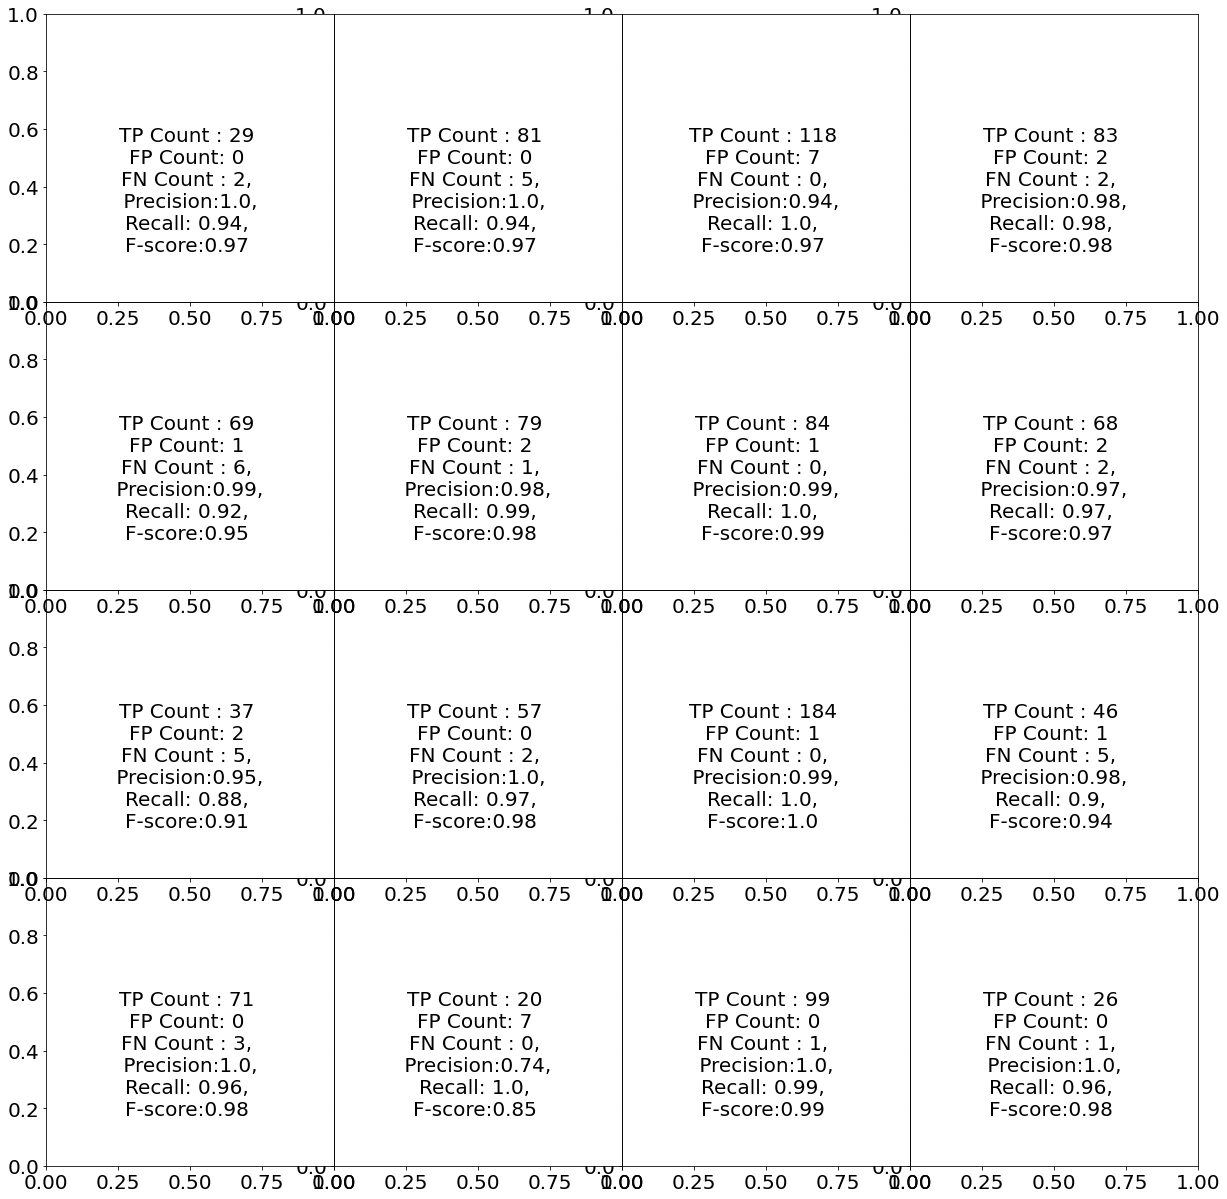

In [48]:
import matplotlib.pyplot as plt
ipynbsections=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
print('SECTION WISE ANALYIS REPORT')
import statistics

text=list()
for i in sections:
    tp, fp, fn= section_analysis[i]['TP'],section_analysis[i]['FP'], section_analysis[i]['FN']
    if len(section_area_analysis[i]['TP'])>2: 
        tp_area_mean= statistics.mean(section_area_analysis[i]['TP'])
        tp_confd_mean= statistics.mean(section_confidence_analysis[i]['TP'])
        if len(section_area_analysis[i]['TP'])>1:
            tp_area_std=  statistics.stdev(section_area_analysis[i]['TP'])
            tp_confd_std = statistics.stdev(section_confidence_analysis[i]['TP'])
        else:
            tp_area_std, tp_confd_std= 'Only 1 value avl', 'Only 1 value avl'
    else:
        tp_area_mean, tp_area_std ='No TP Values', 'No TP Values'
        tp_confd_mean, tp_confd_std=  'No TP Values', 'No TP Values'
        
    if len(section_area_analysis[i]['FP'])>2: 
        fp_area_mean= statistics.mean(section_area_analysis[i]['FP'])
        fp_confd_mean= statistics.mean(section_confidence_analysis[i]['FP'])
        if len(section_area_analysis[i]['TP'])>1:
            fp_area_std=  statistics.stdev(section_area_analysis[i]['FP'])
            fp_confd_std = statistics.stdev(section_confidence_analysis[i]['FP'])
        else:
            fp_area_std,fp_confd_std= 'Only 1 value avl', 'Only 1 value avl'
    else:
        fp_area_mean, fp_area_std ='No FP Values', 'No FP Values'
        fp_confd_mean, fp_confd_std=  'No FP Values', 'No FP Values'
        
    precision = round(tp / (tp+fp),2)
    recall    = round(tp / (tp+fn),2)
    f_score   = round(tp/(tp+((fn+fp)/2)),2)
    #text_temp= 'TP Count : {} {}FP Count: {} {}FN Count : {}, {} TP Area Mean:{}, {}TP Area SDV: {}, {}FP Area Mean:{} {}FP Area SDV: {} {}TP Confidence Mean: {}{}TP Confidence SDV: {} {}FP Confidence Mean: {} {}FP Confidence Sdv: {}'.format(
    #          tp,'\n',fp, '\n',fn, '\n',tp_area_mean,'\n', tp_area_std,'\n',fp_area_mean, '\n',fp_area_std,'\n', tp_confd_mean,'\n', tp_confd_std, '\n', fp_confd_mean, '\n',fp_confd_std )
    text_temp= 'TP Count : {} {}FP Count: {} {}FN Count : {}, {} Precision:{}, {}Recall: {}, {}F-score:{} {}'.format(
              tp,'\n',fp, '\n',fn, '\n',precision,'\n', recall,'\n',f_score, '\n' )

    
    text.append(text_temp)

font = {'size'   : 20}
plt.rc('font', **font)

fig = plt.figure(figsize=(10, 10))

for c in range(4):
    for r in range(4):
        ax1 = fig.add_axes([1.7 - (0.4*r) , 0.4*c, 0.4, 0.4])
        ax1.text(0.5, 0.1, text[-1], ha='center')
        text.pop(-1)


In [59]:
# BELOW IS EXPERIMENTAL ANALYSIS IN TERMS OF WHAT IS AREA AND CONFIDENCE SPREAD FOR DIFFERENT PARAMETERS

Text(0.5, 0, 'FN_areas')

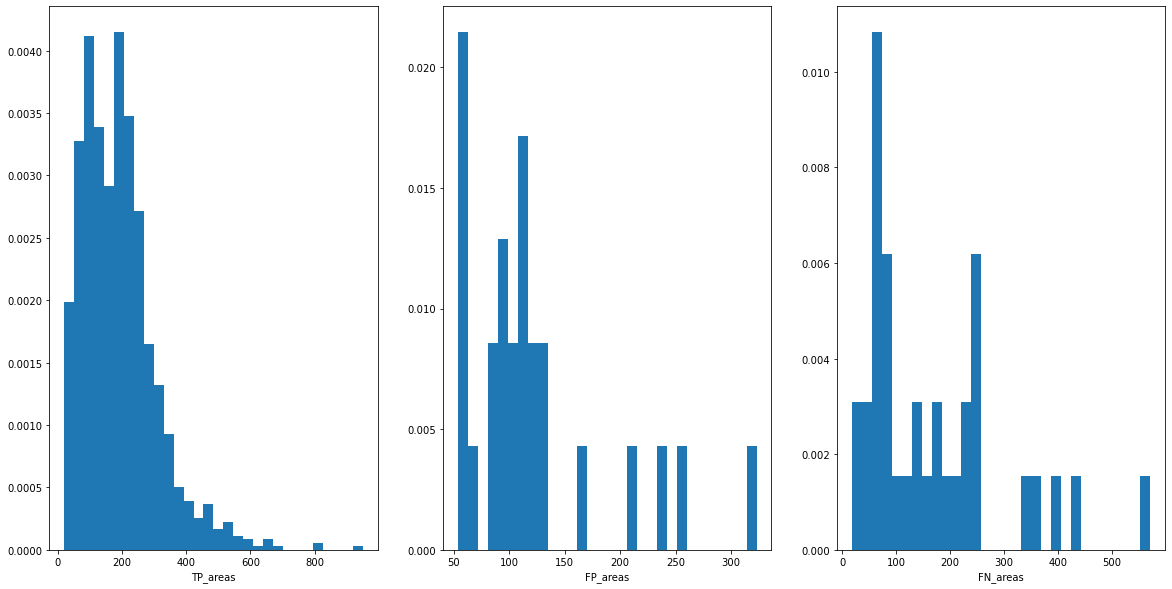

In [29]:

#AREA of bounding box analysis  for TP,FP Aand FN 

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].hist(TP_areas, density=True, bins=30)  # density=False would make counts
ax[0].set_xlabel('TP_areas')

ax[1].hist(FP_areas, density=True, bins=30)  # density=False would make counts
ax[1].set_xlabel('FP_areas')

ax[2].hist(FN_areas, density=True, bins=30)  # density=False would make counts
ax[2].set_xlabel('FN_areas')

Text(0.5, 0, 'FP_confidence')

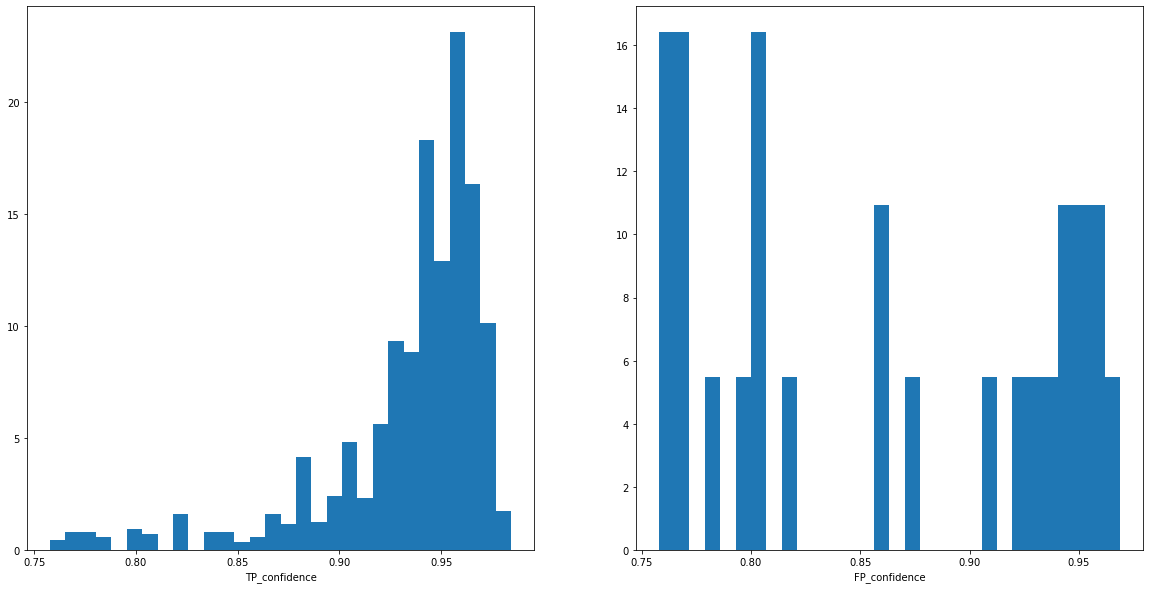

In [30]:
#Confidence Analysis for TP,FP Aand FN 

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(TP_confidence, density=True, bins=30)  # density=False would make counts
ax[0].set_xlabel('TP_confidence')

ax[1].hist(FP_confidence, density=True, bins=30)  # density=False would make counts
ax[1].set_xlabel('FP_confidence')

SECTION AREA WISE ANALYIS REPORT


/home/francesco/libraries/anaconda3/envs/new_integr_3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


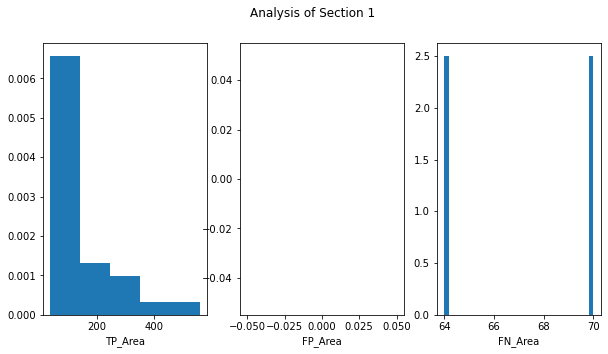

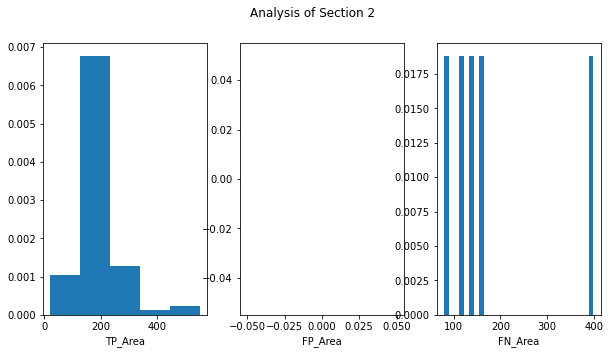

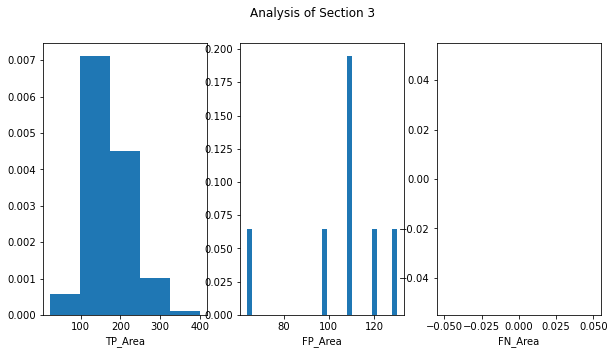

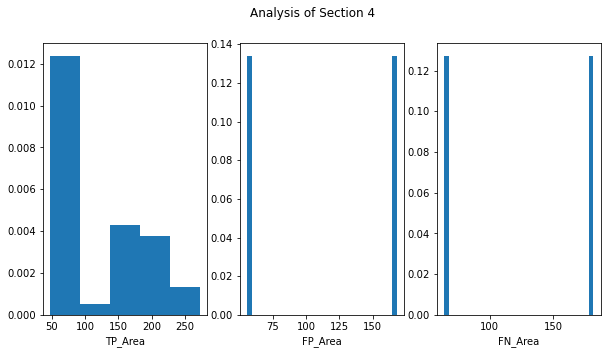

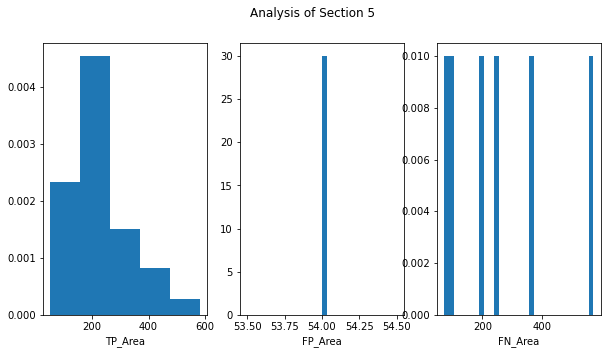

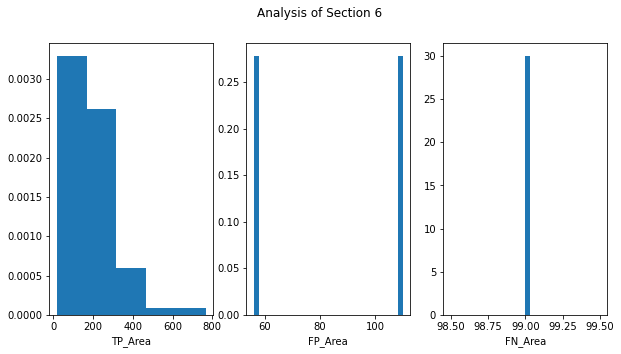

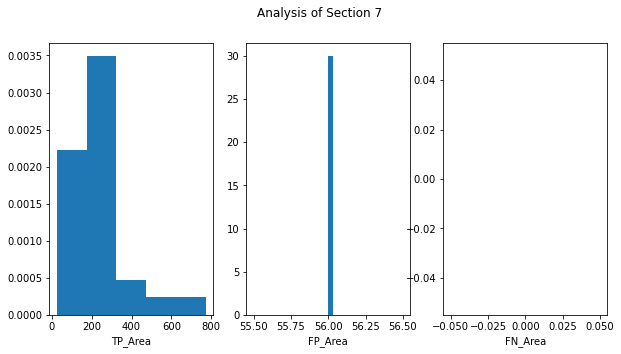

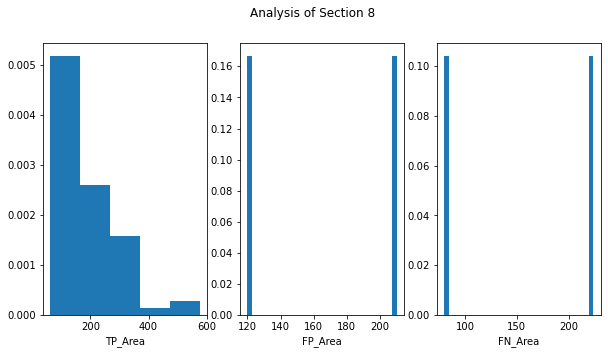

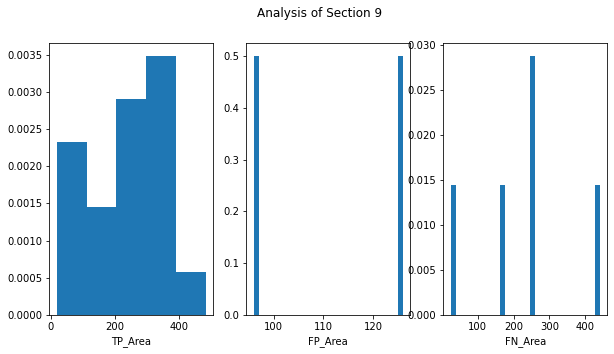

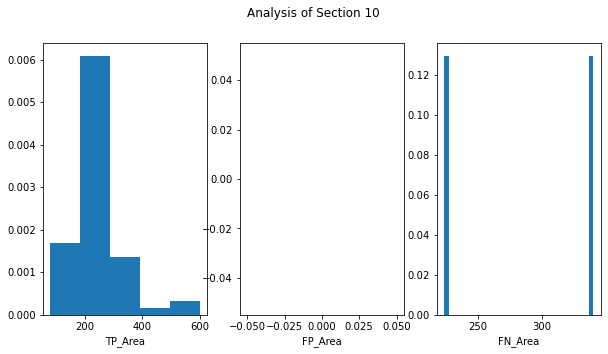

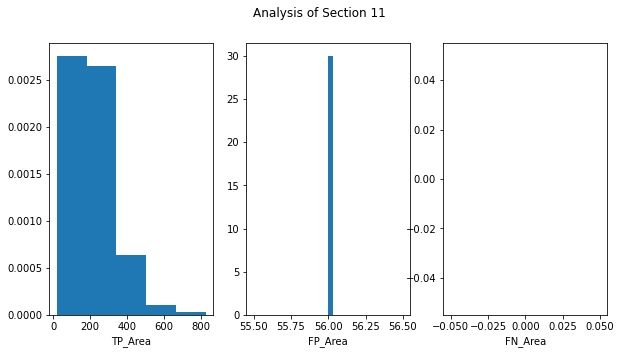

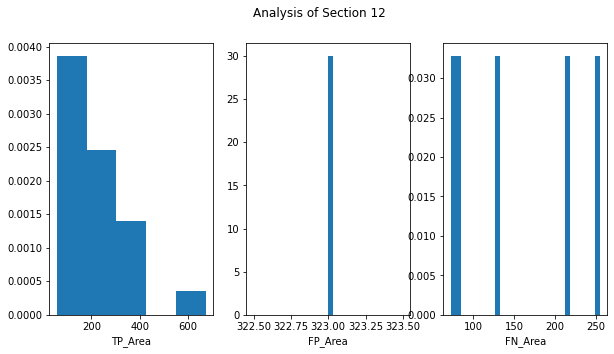

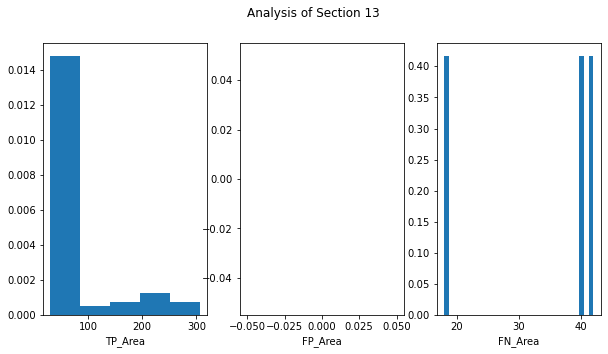

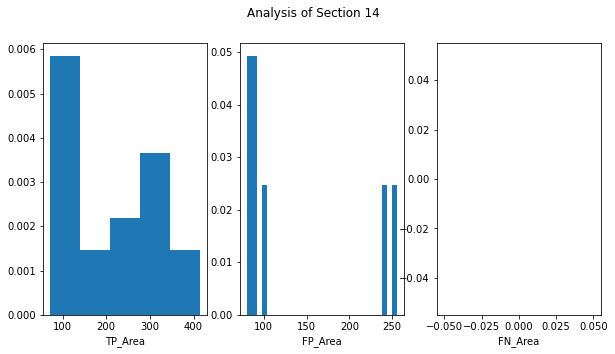

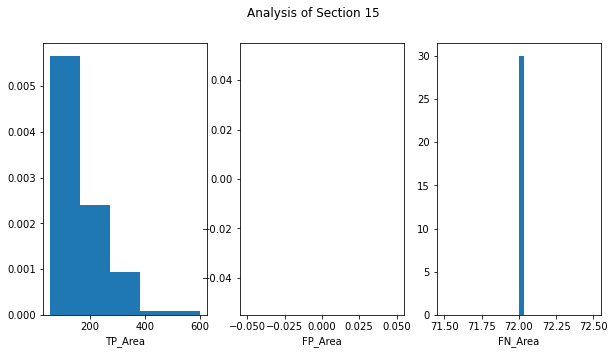

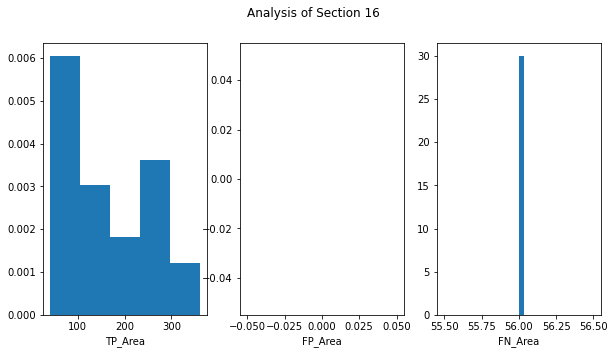

In [31]:

#SECTION WISE AREA ANALYSIS Analysis for TP,FP Aand FN 

sections=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
internal_keys=['TP', 'FP', 'FN']

print('SECTION AREA WISE ANALYIS REPORT')
for i in sections:
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].hist(section_area_analysis[i]['TP'], density=True, bins=5)  # density=False would make counts
    ax[0].set_xlabel('TP_Area')
    
    ax[1].hist(section_area_analysis[i]['FP'], density=True, bins=30)  # density=False would make counts
    ax[1].set_xlabel('FP_Area')
    
    ax[2].hist(section_area_analysis[i]['FN'], density=True, bins=30)  # density=False would make counts
    ax[2].set_xlabel('FN_Area')
    fig.suptitle('Analysis of Section {}'.format(i))

   

SECTION CONFIDENSE WISE ANALYIS REPORT


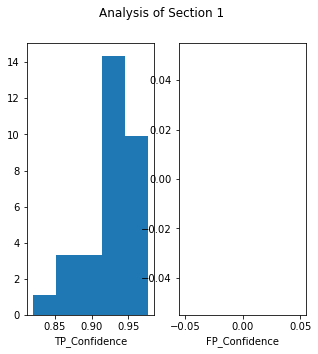

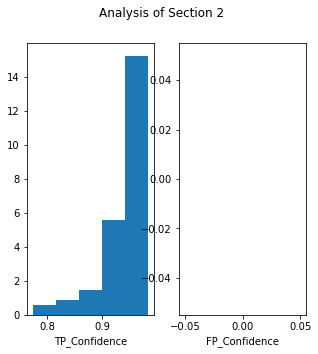

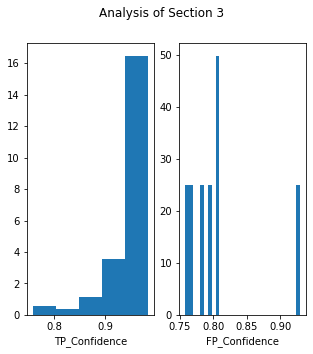

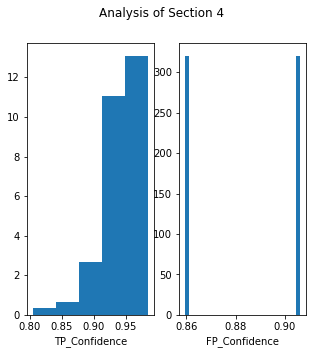

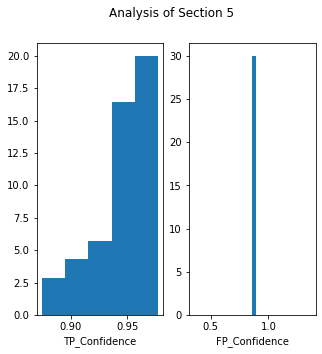

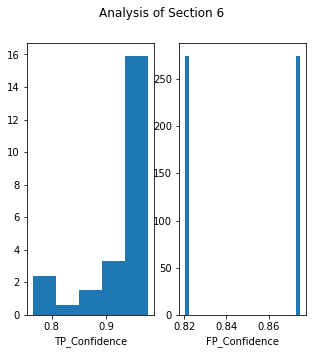

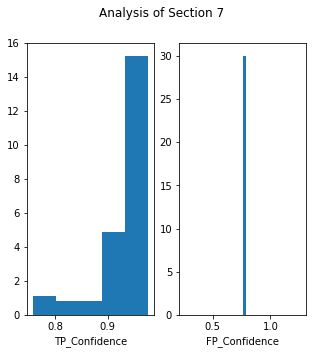

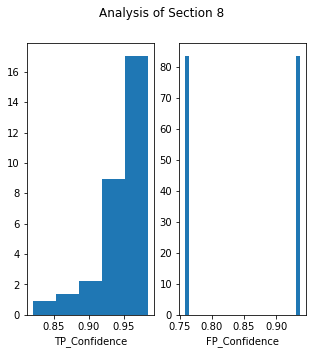

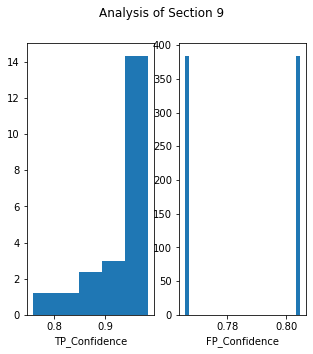

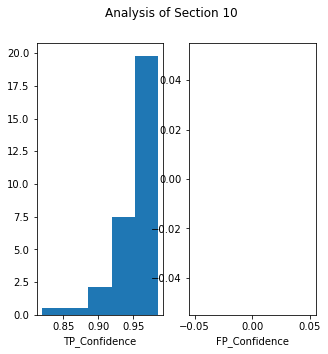

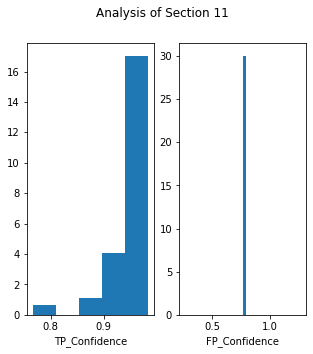

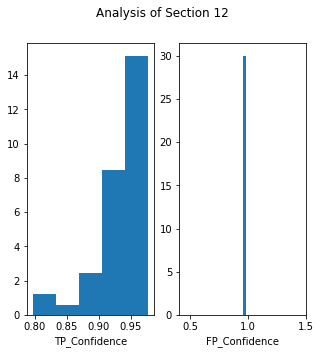

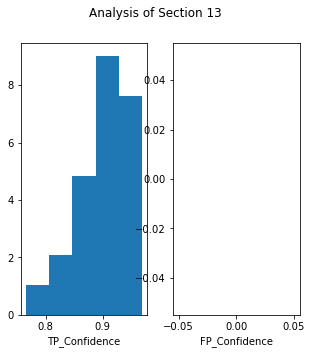

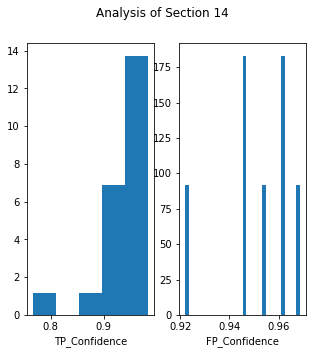

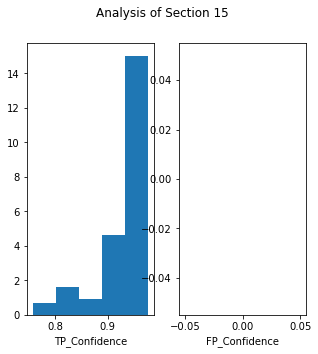

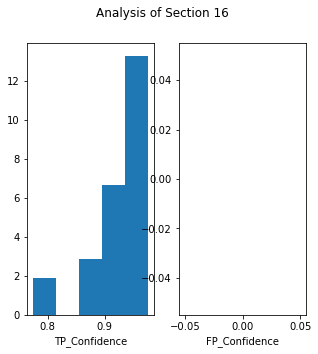

In [17]:

#SECTION WISE CONFIDENCE ANALYSIS for Analysis for TP,FP Aand FN 

sections=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
internal_keys=['TP', 'FP', 'FN']
print('SECTION CONFIDENSE WISE ANALYIS REPORT')
for i in sections:
    fig, ax = plt.subplots(1, 2, figsize=(5, 5))
    ax[0].hist(section_confidence_analysis[i]['TP'], density=True, bins=5)  # density=False would make counts
    ax[0].set_xlabel('TP_Confidence')
    
    ax[1].hist(section_confidence_analysis[i]['FP'], density=True, bins=30)  # density=False would make counts
    ax[1].set_xlabel('FP_Confidence')
    
    fig.suptitle('Analysis of Section {}'.format(i))